In [1]:
import h5py
import numpy as np
import matplotlib.pylab as plt

# Train dataset

- CLD_1: Cloud for image 1 of shape (20,10980,10980); 20 represents 20 rotations

- INPT_1: RGB for image 1 of shape (20,10980,10980,3)

- NIR_1: NIR for image 1 of shape (20,10980,10980)

- GT: Ground Truth for four training images of shape (4,10980,10980)

In [92]:
dset = h5py.File("../data/dataset_rgb_nir_test.hdf5","r")

In [93]:
dset.keys()

<KeysViewHDF5 ['CLD_0', 'CLD_5', 'GT', 'INPT_0', 'INPT_5', 'NIR_0', 'NIR_5']>

In [4]:
dset["NIR_4"].shape

(30, 10980, 10980)

In [6]:
dset["GT"].shape

(4, 10980, 10980)

## Ground truth

- Contains (4,10980,10980) -> Four images

In [94]:
GT = dset["GT"]
GT.shape

(2, 10980, 10980)

In [96]:
import pandas as pd
stats_df = pd.DataFrame(columns=["nodata","max","min","mean","std"], data = np.zeros((4,5)))
# Statistics of GT
for i in range(GT.shape[0]):
    # No Data: pixel value == -1
    nodata_mask = GT[i]<=-1.0
    stats_df.loc[i]["nodata"] = np.sum(nodata_mask)/(GT[i].shape[0]*GT[i].shape[1])
    # With Data distribution
    stats_df.loc[i]["max"] = np.max(GT[i][~nodata_mask])
    stats_df.loc[i]["min"] = np.min(GT[i][~nodata_mask])
    stats_df.loc[i]["mean"] = np.mean(GT[i][~nodata_mask])
    stats_df.loc[i]["std"] = np.std(GT[i][~nodata_mask])
stats_df

nodata   max  min      mean       std
0  0.291790  60.0  0.0  4.828309  8.494777
1  0.635387  60.0  0.0  5.513130  9.415368
2  0.000000   0.0  0.0  0.000000  0.000000
3  0.000000   0.0  0.0  0.000000  0.000000

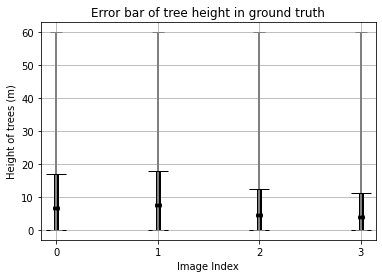

In [97]:
# Visualize data stats
maxs = np.array([60.,60.,60.,60.])
mins = np.array([0.,0.,0.,0.])
means = np.array([6.794608,7.547719,4.438469,3.888517])
stds = np.array([10.290689,10.457384,7.856568,7.422716])
std_err = np.where(means-stds<0, means, stds)
plt.grid()
plt.errorbar(np.arange(4), means, [std_err, stds], fmt="ok", lw=5, capsize = 10, barsabove=True)
plt.errorbar(np.arange(4), means, [means-mins, maxs-means], fmt='.k', ecolor='gray', lw=2, capsize = 6)
plt.xticks(np.arange(4))
plt.xlabel("Image Index")
plt.ylabel("Height of trees (m)")
plt.title("Error bar of tree height in ground truth")
plt.savefig("../fig/gt_test_box.pdf", bbox_inches="tight")
plt.show()

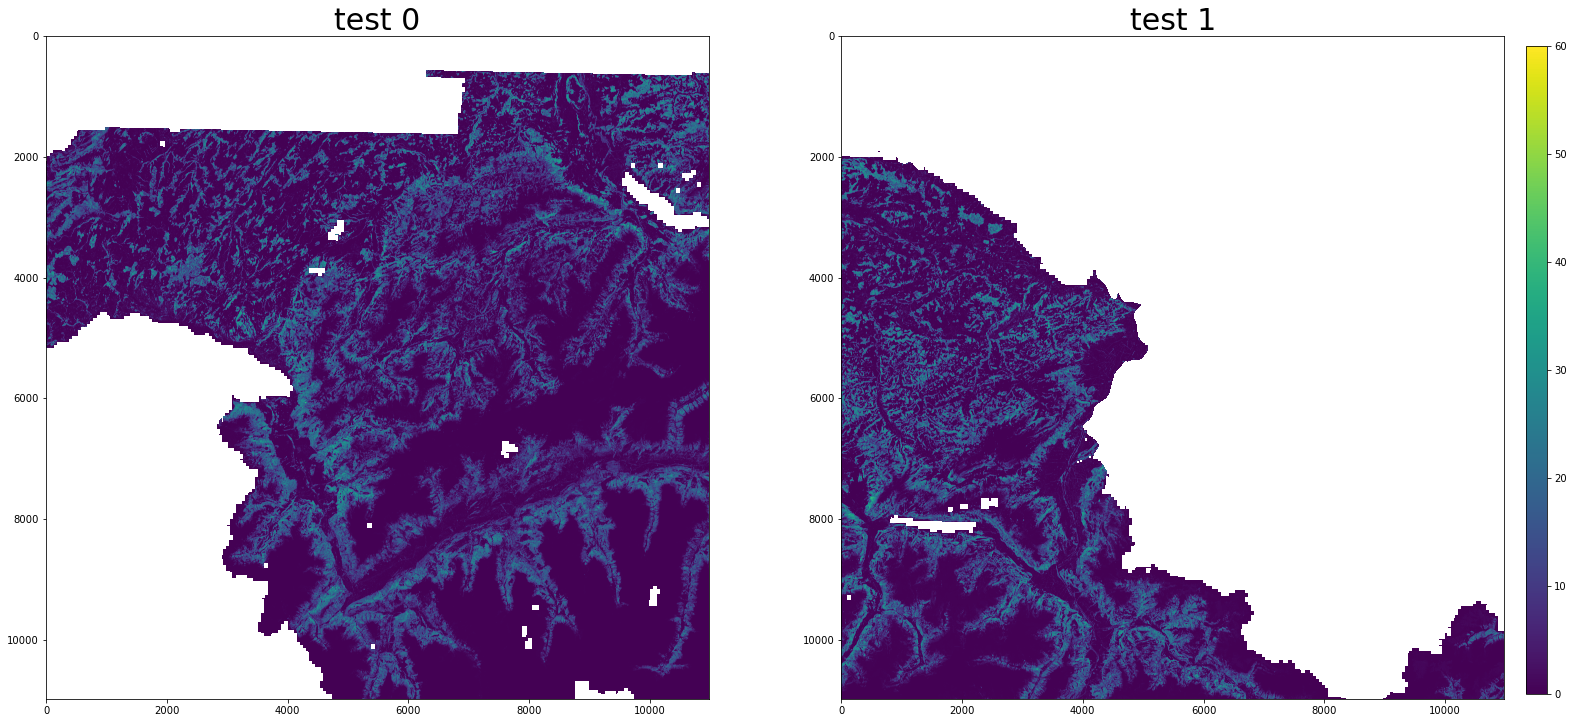

In [99]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Visualize gt
fig, axes = plt.subplots(1, GT.shape[0], figsize=(15*GT.shape[0],15))
for i in range(len(axes)):
    nodata_mask = GT[i]<=-1.0
    data = np.ma.masked_where(nodata_mask, GT[i])
    cbar = axes[i].imshow(data, vmin=0., vmax=60.0)
    axes[i].set_title(f"test {i}", fontsize=30)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.2, 0.01, 0.6])
fig.colorbar(cbar, cax=cbar_ax)
plt.savefig("../fig/gt_test.pdf", bbox_inches="tight")
plt.show()

## Cloud mask

One image contains 20 rotations

In [14]:
cloud = dset["CLD_1"]
cloud.shape

(20, 10980, 10980)

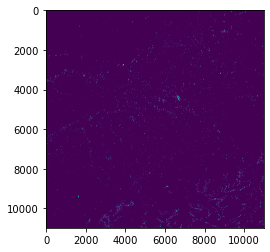

In [47]:
# Visualize rotation 0

plt.imshow(cloud[0], vmin=0, vmax=100)
plt.show()

In [25]:
cloud[0].max()

100

In [26]:
cloud[0].min()

0

In [27]:
cloud[0].mean()

0.4164376528279601

## INPT & NIR

In [45]:
def get_stats(img_arr):
    maxi, mini, meani, stdi, zeros = [],[],[],[],[]
    for i in range(inpt.shape[0]):
        maxi.append(np.max(img_arr[i], axis=(0,1)))
        mini.append(np.min(img_arr[i], axis=(0,1)))
        meani.append(np.mean(img_arr[i], axis=(0,1)))
        stdi.append(np.std(img_arr[i], axis=(0,1)))
        zeros.append(np.sum(img_arr[i]<=1, axis=(0,1))/10980/10980)
    maxi = np.array(maxi)
    mini = np.array(mini)
    meani = np.array(meani)
    stdi = np.array(stdi)
    zeros = np.array(zeros)
    return (maxi,mini,meani,stdi,zeros)

In [100]:
IMAGEIDX = 0
inpt = dset[f"INPT_{IMAGEIDX}"]
nir = dset[f"NIR_{IMAGEIDX}"]

### Basic statistics per rotation

In [101]:
inpt_stats = get_stats(inpt)
nir_stats = get_stats(nir)

In [103]:
# Visualize basic statistics
def plot_stats_per_rotation(ax, stats_arr, title):
    
    ax.plot(stats_arr[:,0], label="r", c="red")
    ax.plot(stats_arr[:,1], label="g", c="green")
    ax.plot(stats_arr[:,2], label="b", c="blue")
    ax.set_xlabel("Rotations")
#     ax.set_ylabel("Pixel values")
#     if title=="zeros":
    ax.set_ylabel("Proportion of Zeros")
    ax.set_xticks(np.arange(stats_arr.shape[0]))
    ax.grid("on")
    ax.set_title(title)

### Zero-value pixels

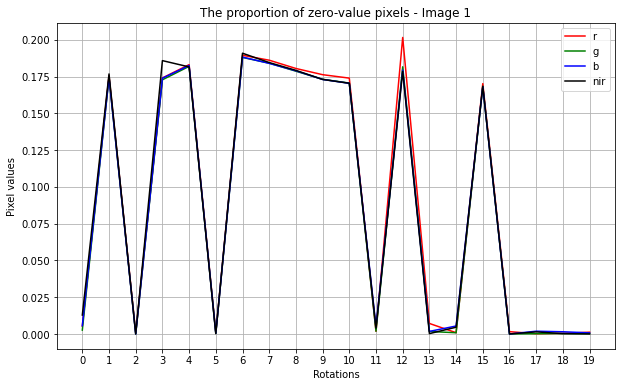

In [91]:
fig, axes = plt.subplots(1,1,figsize=(10,6))
plot_stats_per_rotation(axes, inpt_stats[4], f"The proportion of zero-value pixels - Image {IMAGEIDX}")
axes.plot(nir_stats[4], label="nir", c="black")
plt.legend()
plt.savefig(f"../fig/test_inpt{IMAGEIDX}_stats_zeros.pdf", bbox_inches="tight")
plt.show()

### RGB Error bar per rotation

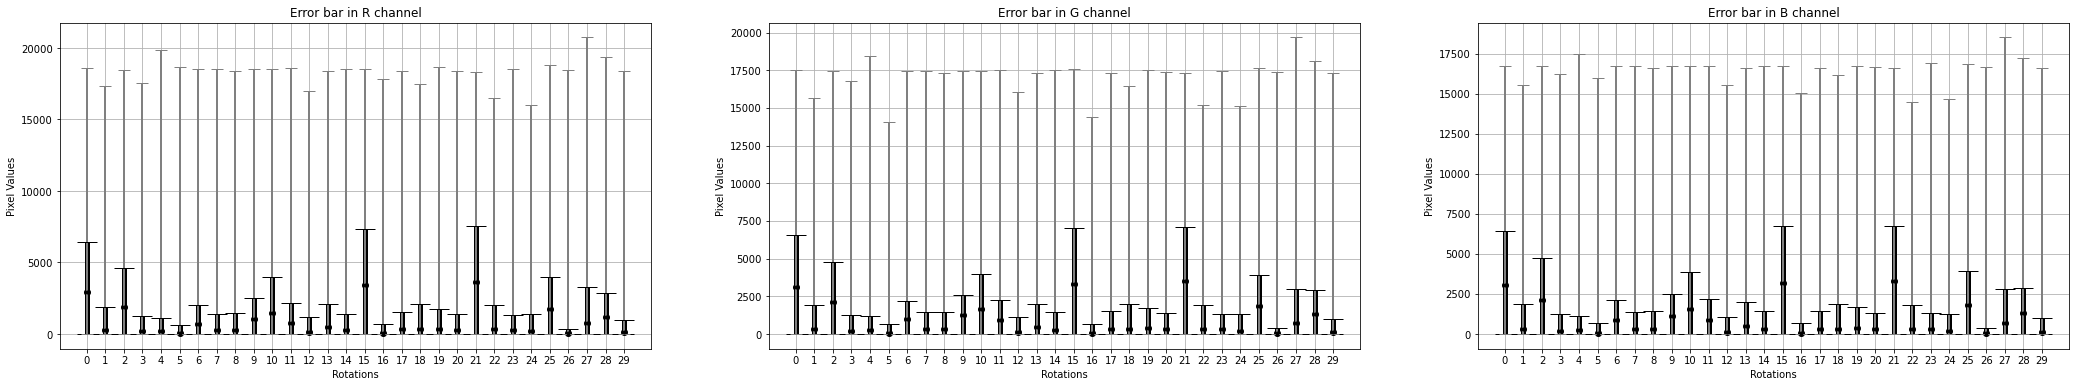

In [62]:
maxs = inpt_stats[0]
mins = inpt_stats[1]
means = inpt_stats[2]
stds = inpt_stats[3]
std_err = np.where(means-stds<0, means, stds)

CHANELS = ["R","G","B"]
fig, axes = plt.subplots(1,3, figsize=(36,6))
for i, ax in enumerate(axes):
    ax.grid()
    ax.errorbar(np.arange(maxs.shape[0]), means[:,i], [std_err[:,i], stds[:,i]], fmt="ok", lw=5, capsize = 10, barsabove=True)
    ax.errorbar(np.arange(maxs.shape[0]), means[:,i], [(means-mins)[:,i], (maxs-means)[:,i]], fmt='.k', ecolor='gray', lw=2, capsize = 6)
    ax.set_xticks(np.arange(maxs.shape[0]))
    ax.set_xlabel("Rotations")
    ax.set_ylabel("Pixel Values")
    ax.set_title(f"Error bar in {CHANELS[i]} channel")
plt.savefig(f"../fig/train_inpt{IMAGEIDX}_box.pdf", bbox_inches="tight")
plt.show()

### Visualize all stats per rotation

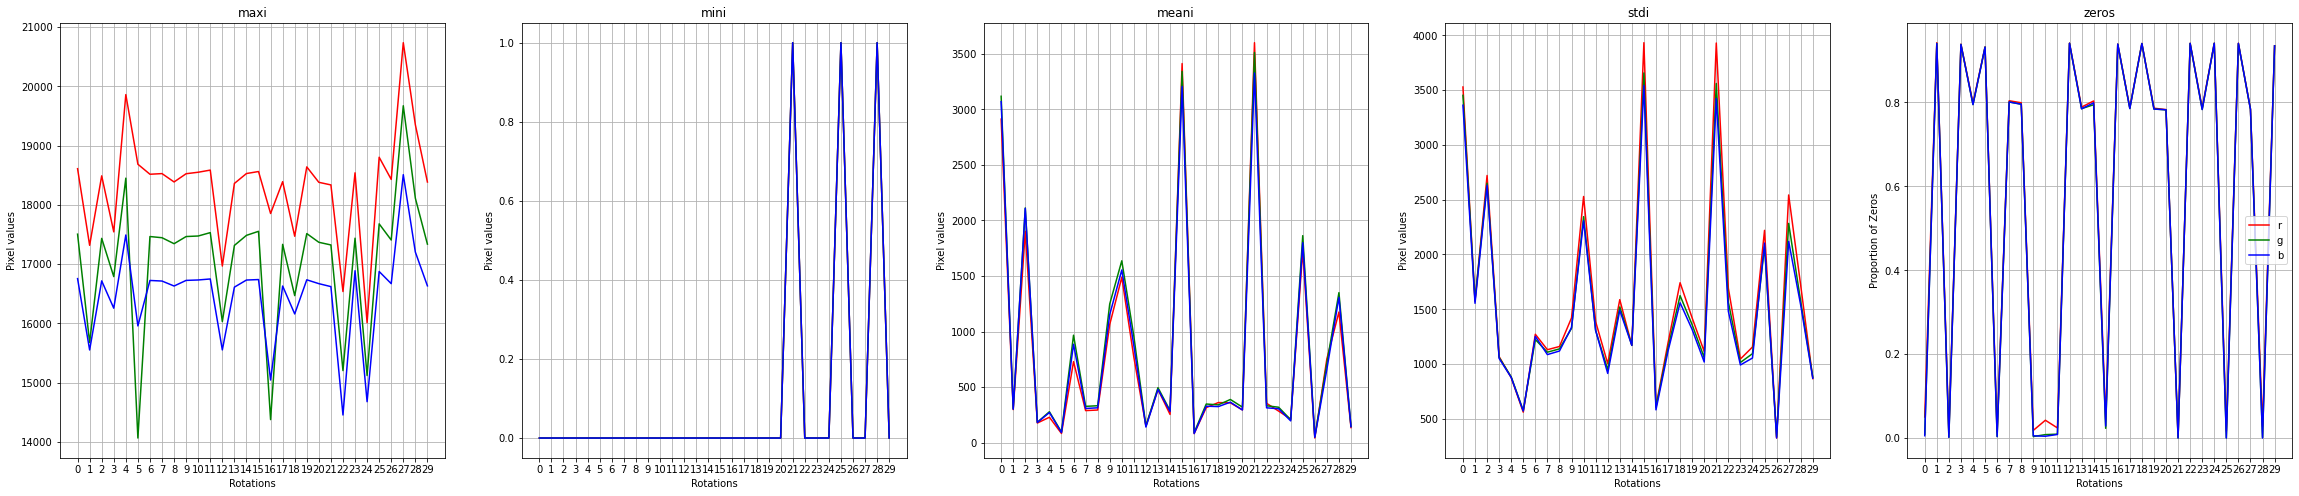

In [48]:
  
fig, axes = plt.subplots(1, len(inpt_stats), figsize=(8*len(inpt_stats),8))
plot_stats_per_rotation(axes[0], inpt_stats[0], "maxi")
plot_stats_per_rotation(axes[1], inpt_stats[1], "mini")
plot_stats_per_rotation(axes[2], inpt_stats[2], "meani")
plot_stats_per_rotation(axes[3], inpt_stats[3], "stdi")
plot_stats_per_rotation(axes[4], inpt_stats[4], "zeros")
plt.legend()
plt.savefig(f"../fig/train_inpt{IMAGEIDX}_stats.pdf", bbox_inches="tight")
plt.show()

Visualization of a rotation in an train image

In [51]:
roatation = 0
normalized = (inpt[roatation]-np.min( inpt[roatation], axis=(0,1)))/(np.max(inpt[roatation], axis=(0,1))-np.min(inpt[roatation], axis=(0,1)))

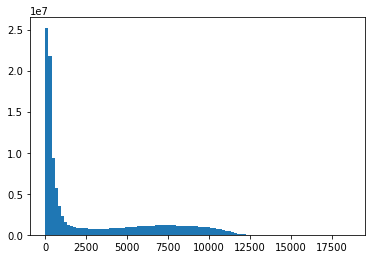

In [50]:
plt.hist(inpt[0][...,0].ravel(), bins=100)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


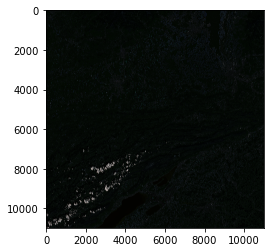

In [192]:
plt.imshow(inpt[0] / 16000.)

## NIR

In [68]:
IMAGEIDX = 4

nir = dset[f"NIR_{IMAGEIDX}"]
nir.shape

(30, 10980, 10980)

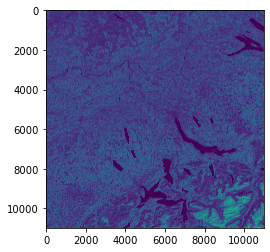

In [29]:
# Visualize rotation 0

plt.imshow(nir[0])
plt.show()

In [69]:
# Basic stats
nir_stats = get_stats(nir)

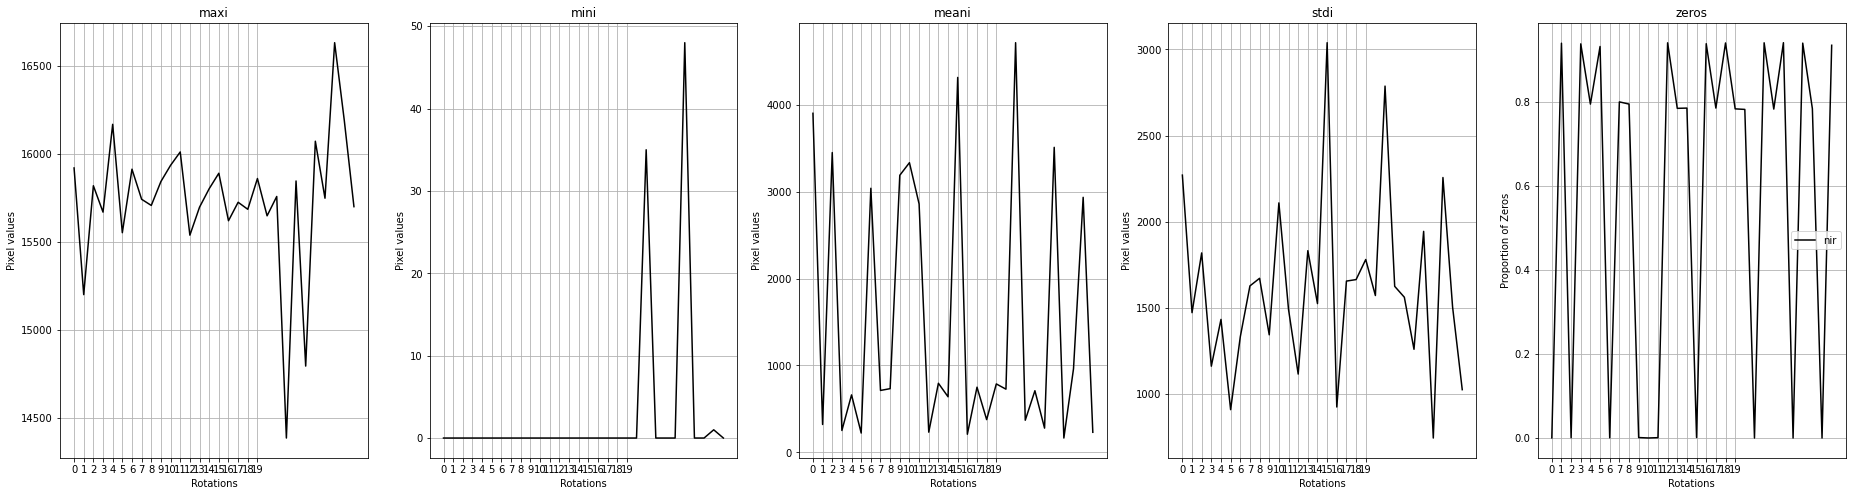

In [70]:
# Visualize basic statistics
def plot_stats_per_rotation(ax, stats_arr, title):
    
    ax.plot(stats_arr, label="nir", c="black")
    ax.set_xlabel("Rotations")
    ax.set_ylabel("Pixel values")
    if title=="zeros":
        ax.set_ylabel("Proportion of Zeros")
    ax.set_xticks(np.arange(20))
    ax.grid("on")
    ax.set_title(title)
    
    
fig, axes = plt.subplots(1,5, figsize=(32,8))
plot_stats_per_rotation(axes[0], nir_stats[0], "maxi")
plot_stats_per_rotation(axes[1], nir_stats[1], "mini")
plot_stats_per_rotation(axes[2], nir_stats[2], "meani")
plot_stats_per_rotation(axes[3], nir_stats[3], "stdi")
plot_stats_per_rotation(axes[4], nir_stats[4], "zeros")
plt.legend()
plt.savefig(f"../fig/train_nir{IMAGEIDX}_stats.pdf", bbox_inches="tight")
plt.show()


# Cloud Mask Out

In [36]:
# Test mask in image-0, rotation-0
cld = cloud[0]
rgb = inpt[0]

How much percentage of the image without cloud?

In [39]:
no_cld_mask = cld==0
no_cld_mask.sum()/cld.shape[0]/cld.shape[1]

0.9699036333655163

In [54]:
del cld, rgb, no_cld_mask

### Now we use all rotations in one image, filter out cloud rotations, take average over the other rotations without cloud

Calculate without-cloud frequency

In [42]:
cld_freq = np.zeros((cloud.shape[1], cloud.shape[2]))
for i in range(cloud.shape[0]):
    cld_freq += cloud[i]==0

In [46]:
cld_freq.mean()

16.72422715916669

- Average between 20 rotations; 

- Ignore pixels with cloud (cloud>0);

- Weighted by without-cloud frequency

For RGB

In [55]:
rgb_merge = np.zeros(inpt[0].shape)
for i in range(cloud.shape[0]):
    rgb_merge += np.where((cloud[i]==0)[:,:,np.newaxis], inpt[i], 0)

In [56]:
rgb_merge.max()

152193.0

In [63]:
rgb_avg = np.where(cld_freq[:,:,np.newaxis]>0, rgb_merge/cld_freq[:,:,np.newaxis], -1)

<ipython-input-63-a1a414e227cb>:1: RuntimeWarning: invalid value encountered in true_divide
  rgb_avg = np.where(cld_freq[:,:,np.newaxis]>0, rgb_merge/cld_freq[:,:,np.newaxis], -1)


In [67]:
rgb_avg.max()

18741.0

For NIR

In [68]:
nir_merge = np.zeros(nir[0].shape)
for i in range(cloud.shape[0]):
    nir_merge += np.where(cloud[i]==0, nir[i], 0)
nir_avg = np.where(cld_freq>0, nir_merge/cld_freq, -1)

<ipython-input-68-d8ff3651d114>:4: RuntimeWarning: invalid value encountered in true_divide
  nir_avg = np.where(cld_freq>0, nir_merge/cld_freq, -1)


In [69]:
nir_avg.max()

16098.0

For GT

In [70]:
GT[0][nir_avg==-1].shape

(268298,)

In [71]:
268298/10980/10980

0.0022254239368814303

In the first image, 0.2% pixels have no data (always covered by cloud)

Finally, we get rgb/nir for one image. This is the average value for no-cloud period.

For Ground Truth, we just add another mask for area with no record (rgb/nir == -1)

## After merge rotations

In [11]:
af_dset = h5py.File("../data/data_train_rgbReduced_delBlankRotations_Standardized.hdf5","r")
af_dset.keys()

<KeysViewHDF5 ['GT', 'INPT', 'NIR']>

In [12]:
af_inpt = af_dset["INPT"][0]

In [9]:
no_data_mask = af_inpt <= -1.0
af_inpt_ma = np.ma.array(af_inpt, mask=no_data_mask)
miu = np.mean(af_inpt_ma, axis=(0,1))
sigma = np.std(af_inpt_ma, axis=(0,1))
norm_af_inpt_ma = (af_inpt_ma - miu)/sigma
norm_af_inpt_ma.shape

(10980, 10980, 3)

In [10]:
maxi = np.max(norm_af_inpt_ma, axis=(0,1))
mini = np.min(norm_af_inpt_ma, axis=(0,1))
sta_af_inpt_ma =  (norm_af_inpt_ma - mini)/(maxi-mini)
sta_af_inpt_ma.shape

KeyboardInterrupt: 

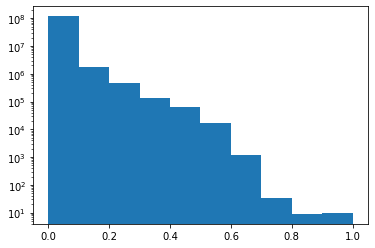

In [175]:
# Distribution of standardized rgb

plt.hist(sta_af_inpt_ma[...,1].ravel())
plt.yscale("log")

<ipython-input-179-9cf8eec6696c>:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  cmap.set_bad('black',1.)


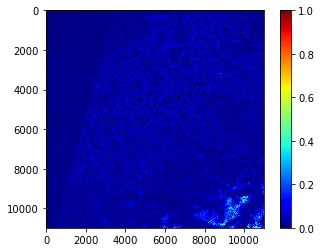

In [179]:
import matplotlib.cm as cm
cmap = cm.jet
cmap.set_bad('black',1.)
cbar = plt.imshow(sta_af_inpt_ma[...,2], interpolation='none', cmap=cmap)
plt.colorbar()
plt.show()

## RGB

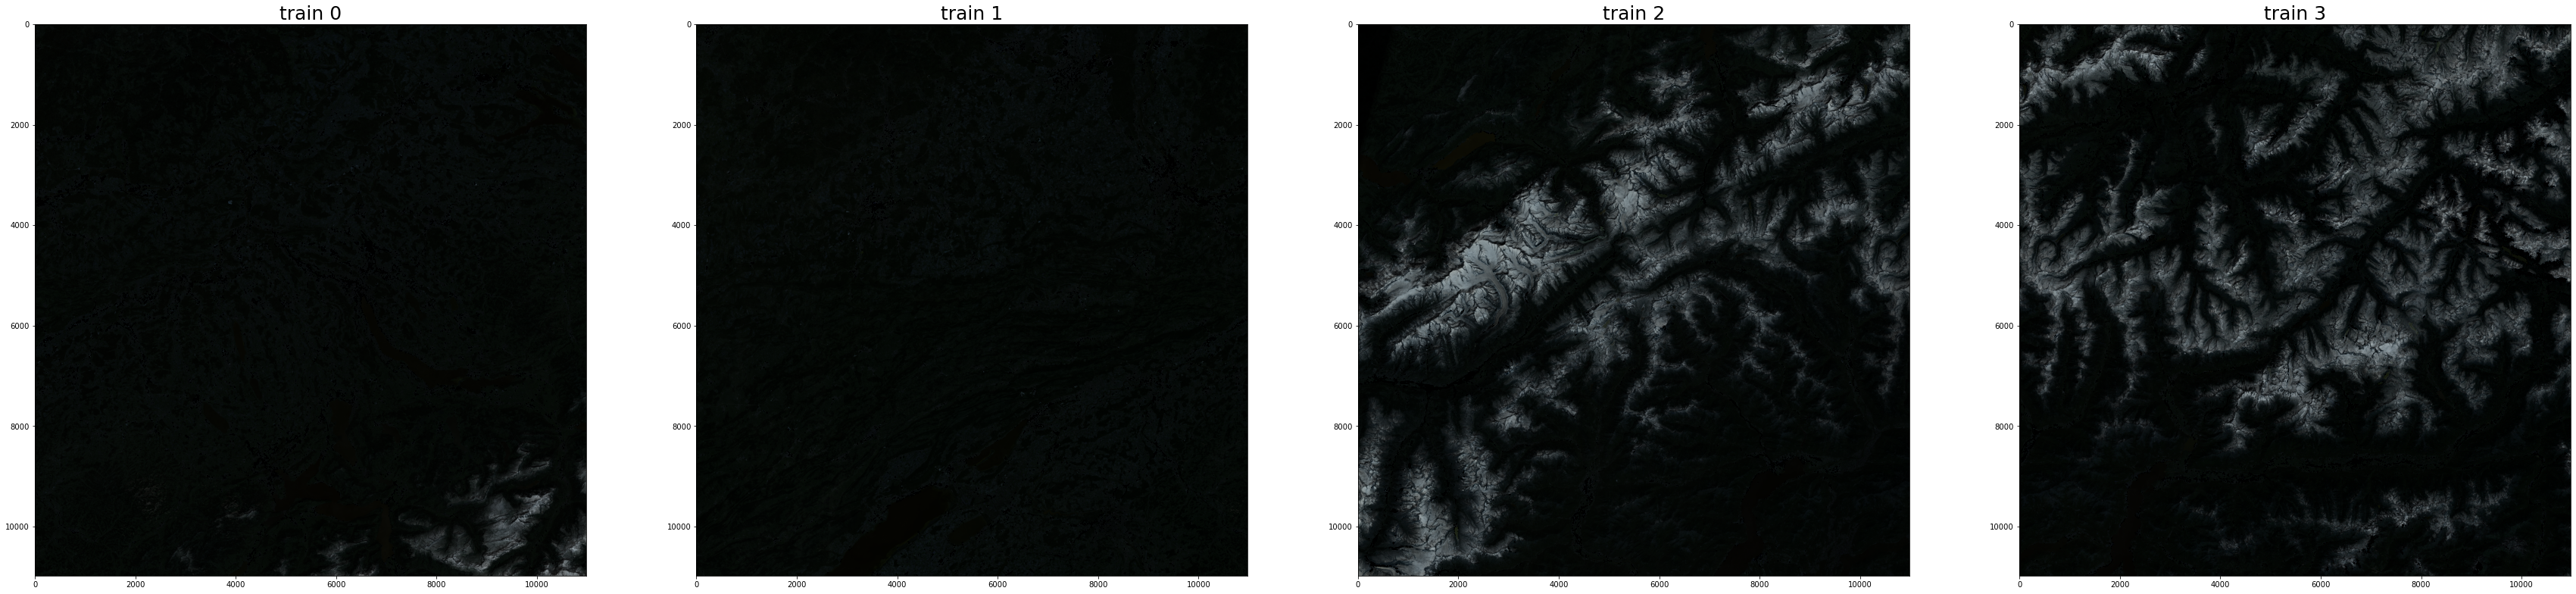

In [38]:
# Visualize
fig, axes = plt.subplots(1, af_dset["INPT"].shape[0], figsize=(60,15))
for i in range(1):
    nodata_mask = (af_dset["INPT"][i]<=-1.0) | (af_dset["GT"][i]<=-1.0)
    data = np.ma.masked_where(nodata_mask, af_dset["INPT"][i])
    axes[i].imshow(data)
    axes[i].set_title(f"train {i}", fontsize=25)
plt.savefig("../fig/rgb_train.pdf", bbox_inches="tight")
plt.show()

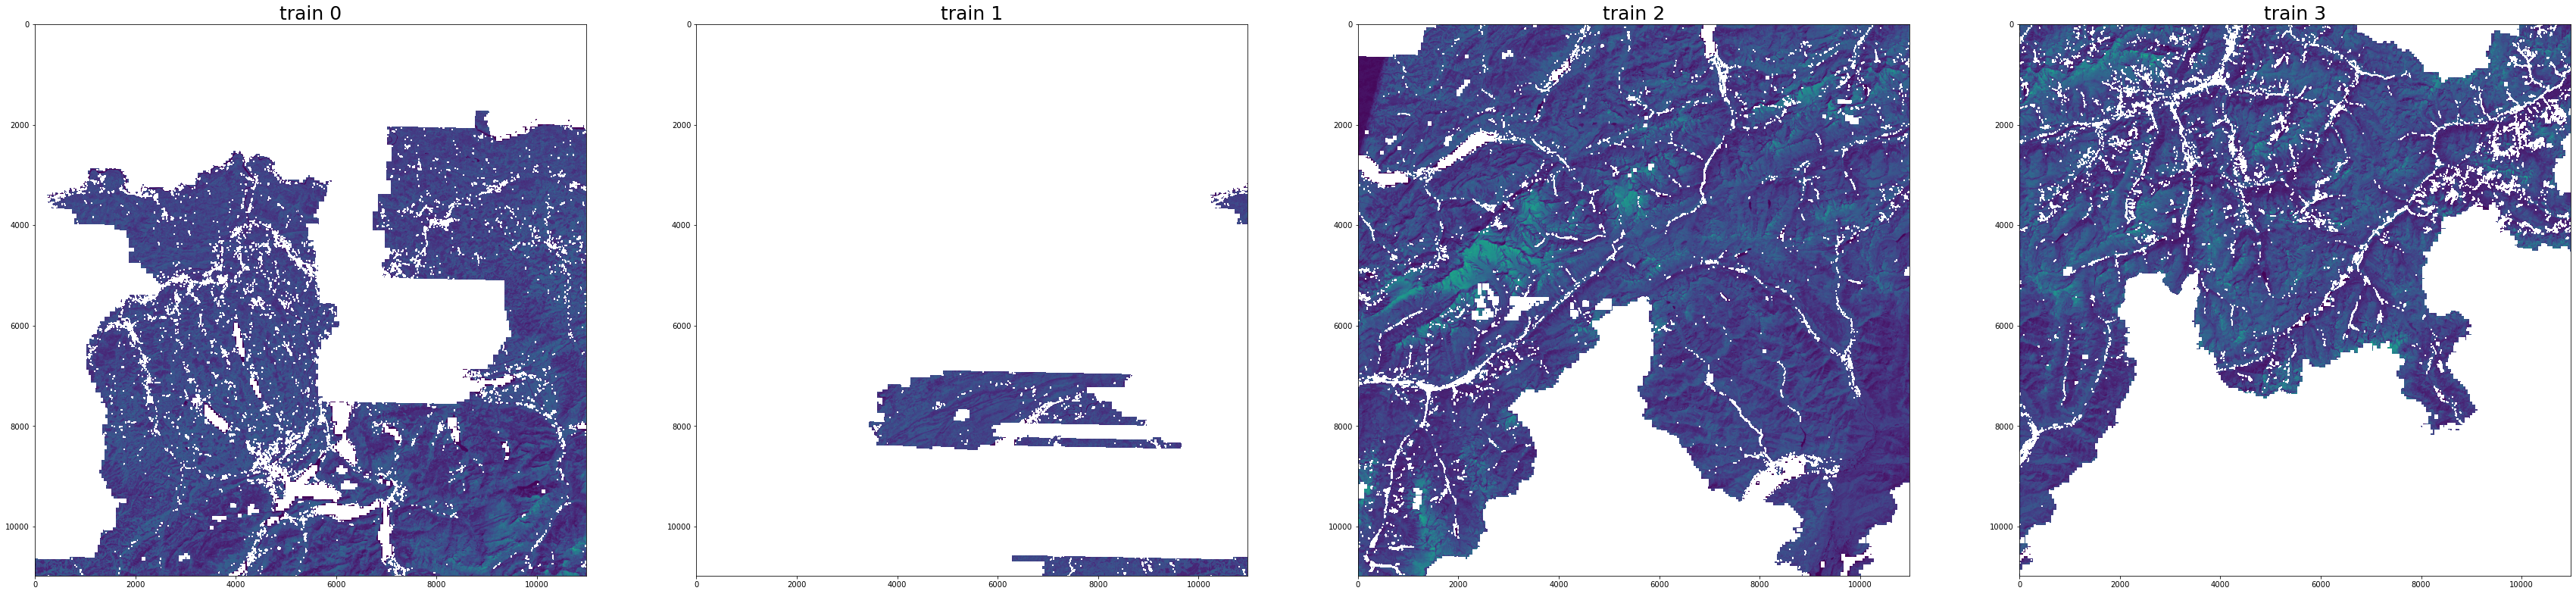

In [30]:
# Visualize
fig, axes = plt.subplots(1, af_dset["NIR"].shape[0], figsize=(60,15))
for i in range(len(axes)):
    nodata_mask = (af_dset["GT"][i]<=-1.0)|(af_dset["NIR"][i]<=-1.0)
    data = np.ma.masked_where(nodata_mask, af_dset["NIR"][i])
    axes[i].imshow(data, vmin=0., vmax=1.)
    axes[i].set_title(f"train {i}", fontsize=25)
plt.savefig("../fig/nir_train.pdf", bbox_inches="tight")
plt.show()